In [79]:
import segment
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import diameter_calc
from typing import Union, Tuple
from skimage import measure
from scipy.ndimage import label
from skimage import morphology

In [2]:
img = cv2.imread("Images/image.png")

In [15]:
img = cv2.imread("Images/25046-retinal-imaging.jpg")

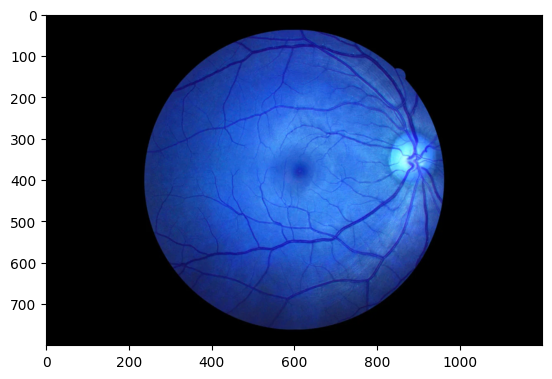

In [16]:
plt.imshow(img)

## Prove varie

In [69]:
def skeletonize(bin: np.ndarray, erosion_shape=cv2.MORPH_RECT, kernel_sz: Union[int, Tuple[int, int]] = 3):
    kernel_sz = fix_kernel(kernel_sz)
    kernel = cv2.getStructuringElement(erosion_shape, kernel_sz)

    thresh = bin.copy()
    skeleton = np.zeros_like(bin)
    eroded = np.zeros_like(bin)
    carry = np.zeros_like(bin)

    while (True):
        cv2.erode(thresh, kernel, dst=eroded)
        cv2.dilate(eroded, kernel, dst=carry)
        cv2.subtract(thresh, carry, dst=carry)
        cv2.bitwise_or(skeleton, carry, dst=skeleton)
        thresh, eroded = eroded, thresh

        if cv2.countNonZero(thresh) == 0:
            return skeleton


def thinning_iteration(img, iter, thinningType):
    rows, cols = img.shape
    marker = np.zeros((rows, cols), dtype=np.uint8)

    if thinningType == "THINNING_ZHANGSUEN":
        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                p2, p3, p4 = img[i-1, j], img[i-1, j+1], img[i, j+1]
                p5, p6, p7 = img[i+1, j+1], img[i+1, j], img[i+1, j-1]
                p8, p9 = img[i, j-1], img[i-1, j-1]

                A = sum((p2 == 0 and p == 1) for p in [p3, p4, p5, p6, p7, p8, p9, p2])
                B = sum([p2, p3, p4, p5, p6, p7, p8, p9])
                m1 = (p2 * p4 * p6) if iter == 0 else (p2 * p4 * p8)
                m2 = (p4 * p6 * p8) if iter == 0 else (p2 * p6 * p8)

                if A == 1 and 2 <= B <= 6 and m1 == 0 and m2 == 0:
                    marker[i, j] = 1

    elif thinningType == "THINNING_GUOHALL":
        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                p2, p3, p4 = img[i-1, j], img[i-1, j+1], img[i, j+1]
                p5, p6, p7 = img[i+1, j+1], img[i+1, j], img[i+1, j-1]
                p8, p9 = img[i, j-1], img[i-1, j-1]

                C = sum((p == 0 and q == 1) for p, q in zip([p2, p4, p6, p8], [p3, p5, p7, p9]))
                N1 = sum((p | q) for p, q in zip([p9, p3, p5, p7], [p2, p4, p6, p8]))
                N2 = sum((p | q) for p, q in zip([p2, p4, p6, p8], [p3, p5, p7, p9]))
                N = min(N1, N2)
                m = ((p6 | p7 | ~p9) & p8) if iter == 0 else ((p2 | p3 | ~p5) & p4)

                if C == 1 and 2 <= N <= 3 and m == 0:
                    marker[i, j] = 1

    img &= ~marker

def thinning(input_img, thinningType):
    processed = input_img.copy()
    processed //= 255

    prev = np.zeros(processed.shape, dtype=np.uint8)
    diff = None

    while True:
        thinning_iteration(processed, 0, thinningType)
        thinning_iteration(processed, 1, thinningType)
        diff = cv2.absdiff(processed, prev)
        prev = processed.copy()
        
        if cv2.countNonZero(diff) == 0:
            break

    processed *= 255
    return processed

In [82]:
def seg(img, t=8, A=200,L=50):  

    # t: Threshold => the threshold used to segment the image (value of 8-10 works best. Otsu and Isodata values do not led to best result)
    # A: Threshold area => All the segments less than A in area are to be removed and considered as noise
    # L: Threshold length => All the centrelines less than L in length are to be removed

    # Resize image to ~(1000px, 1000px) for best results

    # Green Channel
    g = img[:,:,1]

    #Creating mask for restricting FOV
    _, mask = cv2.threshold(g, 10, 255, cv2.THRESH_BINARY)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask = cv2.erode(mask, kernel, iterations=3)

    # CLAHE and background estimation
    clahe = cv2.createCLAHE(clipLimit = 3, tileGridSize=(9,9))
    g_cl = clahe.apply(g)
    g_cl1 = cv2.medianBlur(g_cl, 5)
    bg = cv2.GaussianBlur(g_cl1, (55, 55), 0)

    # Background subtraction
    norm = np.float32(bg) - np.float32(g_cl1)
    norm = norm*(norm>0)

    # Thresholding for segmentation
    _, t = cv2.threshold(norm, t, 255, cv2.THRESH_BINARY)

    # Removing noise points by coloring the contours
    t = np.uint8(t)
    th = t.copy()
    contours, hierarchy = cv2.findContours(t, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        if ( cv2.contourArea(c)< A):
            cv2.drawContours(th, [c], 0, 0, -1)
    th = th*(mask/255)
    th = np.uint8(th)
    #plt.imshow(th, cmap='gray')  # THE SEGMENTED IMAGE

    # Distance transform for maximum diameter
    vessels = th.copy()
    _,ves = cv2.threshold(vessels, 30, 255, cv2.THRESH_BINARY)
    dist = cv2.distanceTransform(vessels, cv2.DIST_L2, 3)
    _,mv,_,mp = cv2.minMaxLoc(dist)
    print("Maximum diameter:",mv*2,"at the point:", mp)
    #print("Select the vessel and press Q after selection.") 

    # Centerline extraction using Zeun-Shang's thinning algorithm
    # Using opencv-contrib-python which provides very fast and efficient thinning algorithm
    # The package can be installed using pip
    #thinned = cv2.ximgproc.thinning(th)
    #thinned = skeletonize(th)
    #thinned = thinning(th, 'THINNING_ZHANGSUEN')
    thinned = morphology.medial_axis(th)
    plt.imshow(thinned, cmap='gray')

    # Filling broken lines via morphological closing using a linear kernel
    kernel = np.ones((1, 10), np.uint8)
    d_im = cv2.dilate(thinned, kernel)
    e_im = cv2.erode(d_im, kernel) 
    num_rows, num_cols = thinned.shape
    for i in range (1, 360//15):
        rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 15*i, 1)
        img_rotation = cv2.warpAffine(thinned, rotation_matrix, (num_cols, num_rows))
        temp_d_im = cv2.dilate(img_rotation, kernel)
        temp_e_im = cv2.erode(temp_d_im, kernel) 
        rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), -15*i, 1)
        im = cv2.warpAffine(temp_e_im, rotation_matrix, (num_cols, num_rows))
        e_im = np.maximum(im, e_im)

    # Skeletonizing again to remove unwanted noise
    #plt.imshow(e_im, cmap='gray')
    #thinned1 = cv2.ximgproc.thinning(e_im)
    #thinned1 = skeletonize(e_im)
    #thinned1 = thinning(e_im, 'THINNING_ZHANGSUEN')
    thinned = morphology.medial_axis(e_im)
    thinned1 = thinned1*(mask/255)
    plt.imshow(thinned1, cmap='gray')

    return thinned1

Maximum diameter: 16.684356689453125 at the point: (604, 386)


error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'dilate'
> Overload resolution failed:
>  - src data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


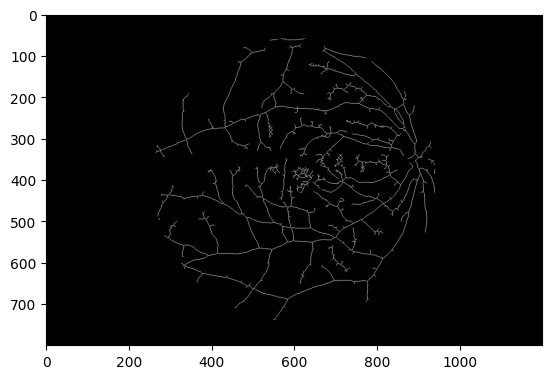

In [83]:
skeleton = seg(img)
# Segment Identification and Measure Actual Lengths
labels,num = measure.label(skeleton, return_num=True, connectivity=2)

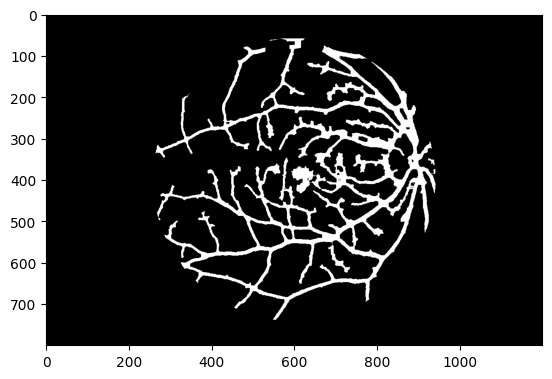

In [81]:
plt.imshow(skeleton, cmap='gray')

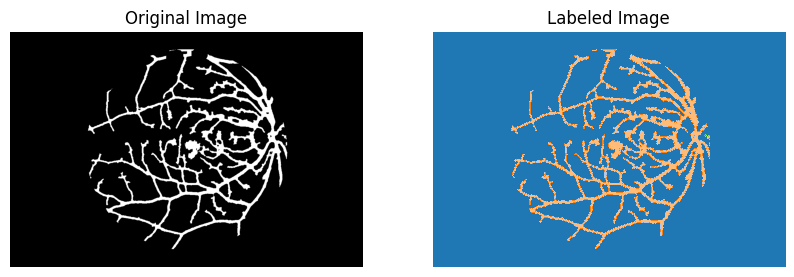

In [74]:
# Plotting
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(skeleton, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Labeled image
plt.subplot(1, 2, 2)
plt.imshow(labels, cmap='tab20') 
plt.title('Labeled Image')
plt.axis('off')

plt.show()

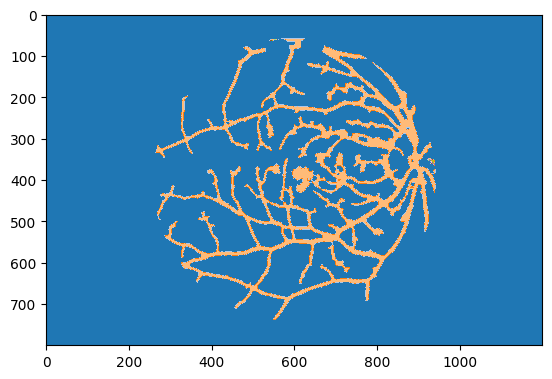

In [75]:
plt.imshow(labels, cmap='tab20') 

In [76]:
num

6

## More Clean

In [143]:
def seg(img, t=8, A=200,L=50):  

    # t: Threshold => the threshold used to segment the image (value of 8-10 works best. Otsu and Isodata values do not led to best result)
    # A: Threshold area => All the segments less than A in area are to be removed and considered as noise
    # L: Threshold length => All the centrelines less than L in length are to be removed

    # Resize image to ~(1000px, 1000px) for best results
    #img = cv2.resize(img, (1000, 1000))
    
    # Green Channel
    g = img[:,:,1]

    #Creating mask for restricting FOV
    _, mask = cv2.threshold(g, 10, 255, cv2.THRESH_BINARY)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask = cv2.erode(mask, kernel, iterations=3)

    # CLAHE and background estimation
    clahe = cv2.createCLAHE(clipLimit = 3, tileGridSize=(9,9))
    g_cl = clahe.apply(g)
    g_cl1 = cv2.medianBlur(g_cl, 5)
    bg = cv2.GaussianBlur(g_cl1, (55, 55), 0)

    # Background subtraction
    norm = np.float32(bg) - np.float32(g_cl1)
    norm = norm*(norm>0)

    # Thresholding for segmentation
    _, t = cv2.threshold(norm, t, 255, cv2.THRESH_BINARY)

    # Removing noise points by coloring the contours
    t = np.uint8(t)
    th = t.copy()
    contours, hierarchy = cv2.findContours(t, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        if ( cv2.contourArea(c)< A):
            cv2.drawContours(th, [c], 0, 0, -1)
    th = th*(mask/255)
    th = np.uint8(th)
    #plt.imshow(th, cmap='gray')  # THE SEGMENTED IMAGE

    # Distance transform for maximum diameter
    vessels = th.copy()
    _,ves = cv2.threshold(vessels, 30, 255, cv2.THRESH_BINARY)
    dist = cv2.distanceTransform(vessels, cv2.DIST_L2, 3)
    _,mv,_,mp = cv2.minMaxLoc(dist)
    print("Maximum diameter:",mv*2,"at the point:", mp)
    #print("Select the vessel and press Q after selection.") 

    # Centerline extraction using Zeun-Shang's thinning algorithm
    # Using opencv-contrib-python which provides very fast and efficient thinning algorithm
    # The package can be installed using pip
    thinned = cv2.ximgproc.thinning(th)
    plt.imshow(thinned, cmap='gray')

    # Filling broken lines via morphological closing using a linear kernel
    kernel = np.ones((1, 10), np.uint8)
    d_im = cv2.dilate(thinned, kernel)
    e_im = cv2.erode(d_im, kernel) 
    num_rows, num_cols = thinned.shape
    for i in range (1, 360//15):
        rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 15*i, 1)
        img_rotation = cv2.warpAffine(thinned, rotation_matrix, (num_cols, num_rows))
        temp_d_im = cv2.dilate(img_rotation, kernel)
        temp_e_im = cv2.erode(temp_d_im, kernel) 
        rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), -15*i, 1)
        im = cv2.warpAffine(temp_e_im, rotation_matrix, (num_cols, num_rows))
        e_im = np.maximum(im, e_im)

    # Skeletonizing again to remove unwanted noise
    #plt.imshow(e_im, cmap='gray')
    thinned1 = cv2.ximgproc.thinning(e_im)
    thinned1 = thinned1*(mask/255)
    plt.imshow(thinned1, cmap='gray')

    # Removing bifurcation points by using specially designed kernels
    thinned1 = np.uint8(thinned1)
    thh = thinned1.copy()
    hi = thinned1.copy()
    thi = thinned1.copy()
    hi = cv2.cvtColor(hi, cv2.COLOR_GRAY2BGR)
    thi = cv2.cvtColor(thi, cv2.COLOR_GRAY2BGR)
    thh = thh/255
    kernel1 = np.array([[1,0,1],[0,1,0],[0,1,0]])
    kernel2 = np.array([[0,1,0],[1,1,1],[0,0,0]])
    kernel3 = np.array([[0,1,0],[0,1,1],[1,0,0]])
    kernel4 = np.array([[1,0,1],[0,1,0],[0,0,1]])
    kernel5 = np.array([[1,0,1],[0,1,0],[1,0,1]])
    kernels = [kernel1, kernel2, kernel3, kernel4, kernel5]
    for k in kernels:
        k1 = k
        k2 = cv2.rotate(k1, cv2.ROTATE_90_CLOCKWISE)
        k3 = cv2.rotate(k2, cv2.ROTATE_90_CLOCKWISE)
        k4 = cv2.rotate(k3, cv2.ROTATE_90_CLOCKWISE)
        ks = [k1, k2, k3, k4]
        for kernel in ks:
            th = cv2.filter2D(thh, -1, kernel)
            for i in range(th.shape[0]):
                for j in range(th.shape[1]):
                    if(th[i,j]==4.0):
                        cv2.circle(hi, (j, i), 2, (0, 255, 0), 2)
                        cv2.circle(thi, (j, i), 2, (0, 0, 0), 2)

    plt.figure(figsize=(20, 14))
    thi = cv2.cvtColor(thi, cv2.COLOR_BGR2GRAY)
    #plt.imshow(hi, cmap='gray')  # This image shows all the bifurcation points

    # Removing centerlines which are smaller than L=50 px in length
    cl = thi.copy()
    contours, hierarchy = cv2.findContours(thi, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        if (c.size<L):
            cv2.drawContours(cl, [c], 0, 0, -1)


    # Centerline superimposed on green channel
    colors = [(100, 0, 150), (102, 0, 255), (0, 128, 255), (255, 255, 0), (10, 200, 10)]
    colbgr = [(193, 182, 255), (255, 0, 102), (255, 128, 0), (0, 255, 255), (10, 200, 10)]

    im = g.copy()
    im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
    thc = cl
    thh = thc.copy()
    thh = cv2.cvtColor(thh, cv2.COLOR_GRAY2BGR)
    # plt.imshow(thh, cmap='gray') 
    contours, heirarchy = cv2.findContours(thc, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    complex = calculate_complexity(contours, L, cl)
    for c in contours:
        
            color = np.random.randint(len(colors))
            cv2.drawContours(im, c, -1, colbgr[color], 2, cv2.LINE_AA)

            
            

    #cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    #cv2.resizeWindow('image', (int(im.shape[1]/2), int(im.shape[0]/2)))
    #cv2.moveWindow('image', 40,30)  # Move it to (40,30)
    #cv2.imshow('image', cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    #cv2.waitKey()
    #cv2.destroyAllWindows()

    # Maximum diameter estimate
    d = mv*1.5
    
    return im, cl, d, thh, complex, contours
    

def calculate_complexity(contours, L, cl):
    '''
    Complexity is defined as the number of segments divided by the sum of all segmented pixels within the image
    '''
    total_pixels = 0
    remaining_segments = 0
    
    for c in contours:
        if (c.size >= L):
            remaining_segments += 1
            total_pixels += c.size
        else:
            cv2.drawContours(cl, [c], 0, 0, -1)
    
    # Complexity calculation
    complexity = remaining_segments / total_pixels if total_pixels > 0 else 0
    return complexity

Maximum diameter: 16.684356689453125 at the point: (604, 386)


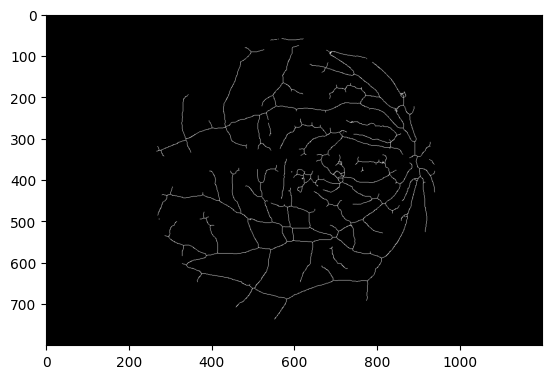

<Figure size 2000x1400 with 0 Axes>

In [144]:
im, cl, d, thh, complex, contours = seg(img)

In [139]:
complex

0.0058924529774447825

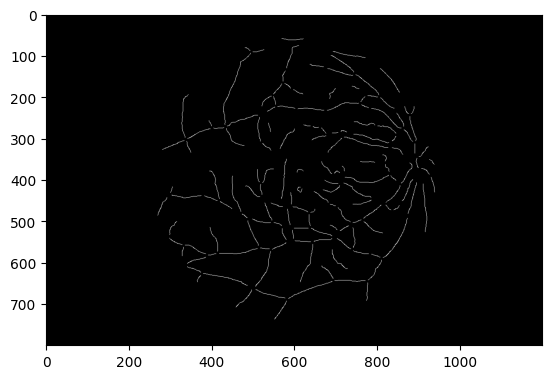

In [140]:
plt.imshow(thh, cmap='gray') 

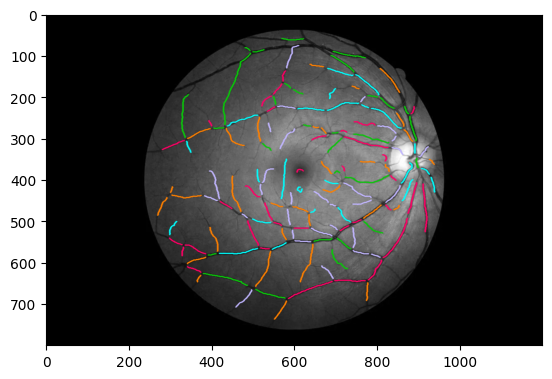

In [141]:
plt.imshow(im, cmap='gray') 

In [146]:
vassel1 = contours[0]

In [149]:
# Measure widths along the vassel at specific points
for point in vassel1:
    x, y = point[0][0], point[0][1]  # Extract x and y coordinates
    #print(x, y)

In [ ]:
points = cv2.findNonZero(Cp)


In [127]:
# Some global variables
ims=0
para=True
para1=True
contour=0
ps=0
imggg=0
C=0
parts = []
index = -1
ims1 = 0
ps1=0

def select(img):
    global ims, para, contour, ps, imggg, C, parts, index, para1, ims1, ps1


    # Segmentation
    im, cl, d = segment.seg(img)

    # Setting values of the global variables
    ps = cl.copy()
    imggg = im
    j = imggg.copy()
    ims = imggg.copy()
    C = np.zeros(ims.shape, np.uint8)
    contour = None
    para = True

    # Finding all the points on the contour 
    Cp = cv2.cvtColor(C, cv2.COLOR_BGR2GRAY)
    point = cv2.findNonZero(Cp)

    # Number of parts to which the contour should be divided
    num_parts = 3

    return Cp, point

Maximum diameter: 16.684356689453125 at the point: (604, 386)
Select the vessel and press Q after selection.


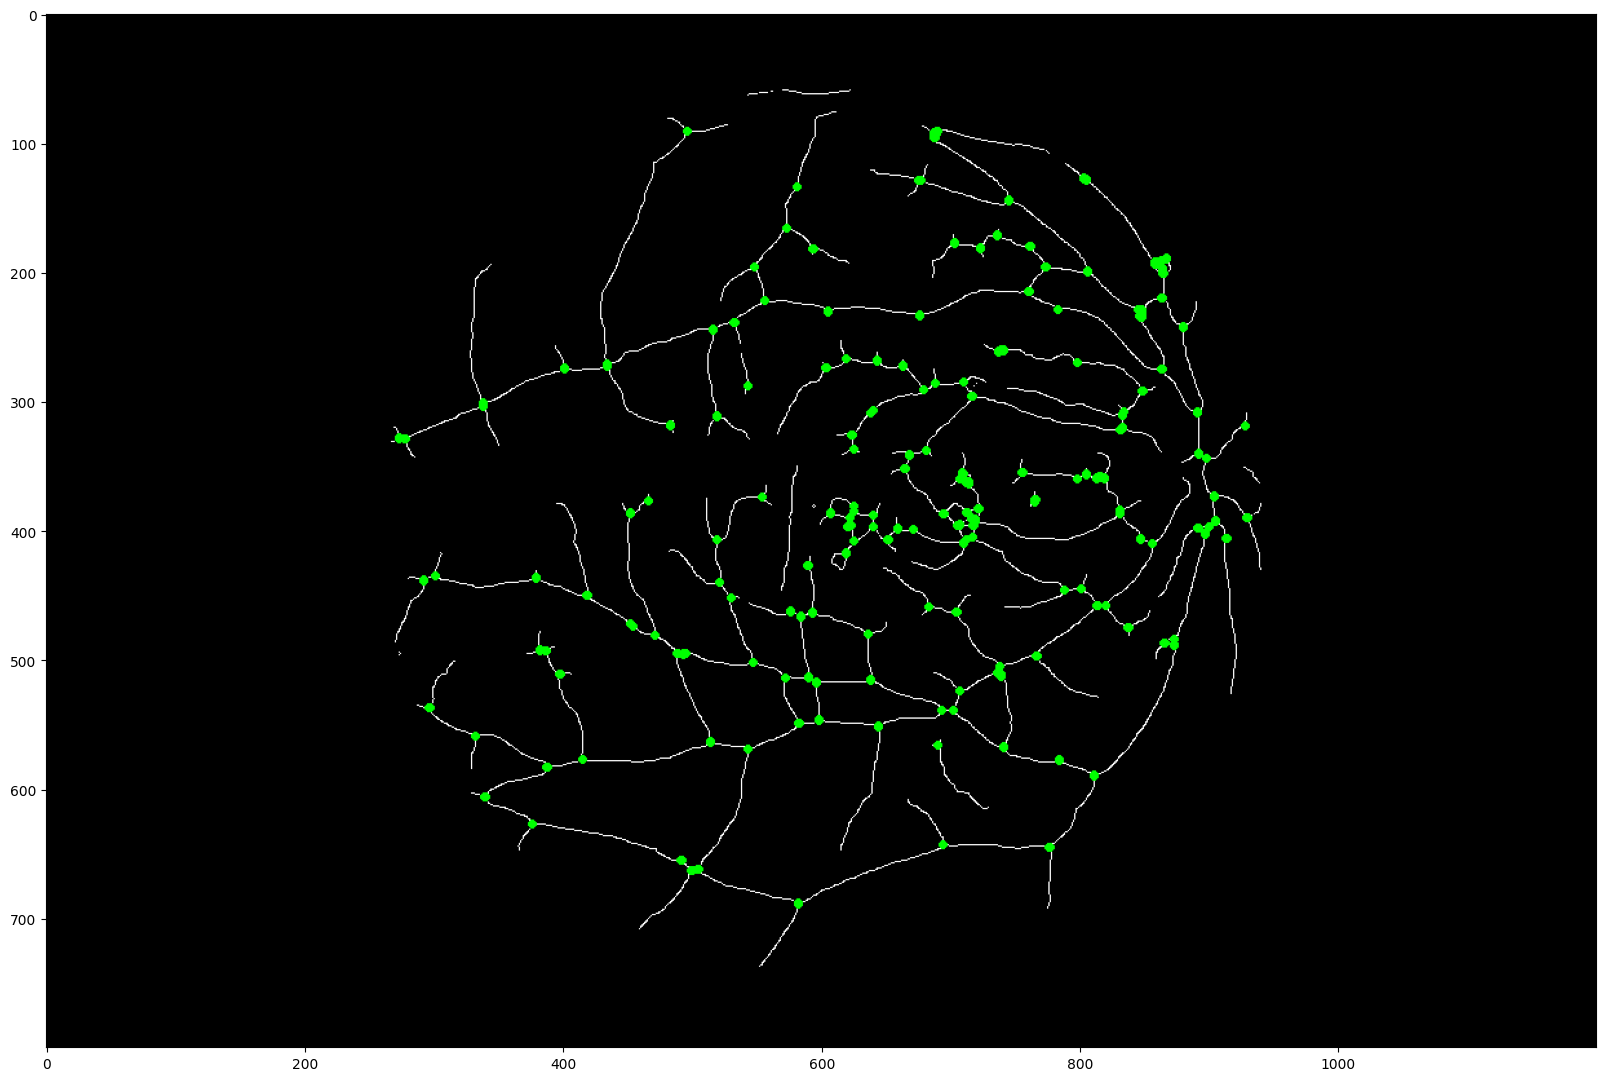

In [128]:
Cp, point = select(img)

In [129]:
Cp

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [130]:
point

## From library

Maximum diameter: 16.684356689453125 at the point: (604, 386)
Select the vessel and press Q after selection.


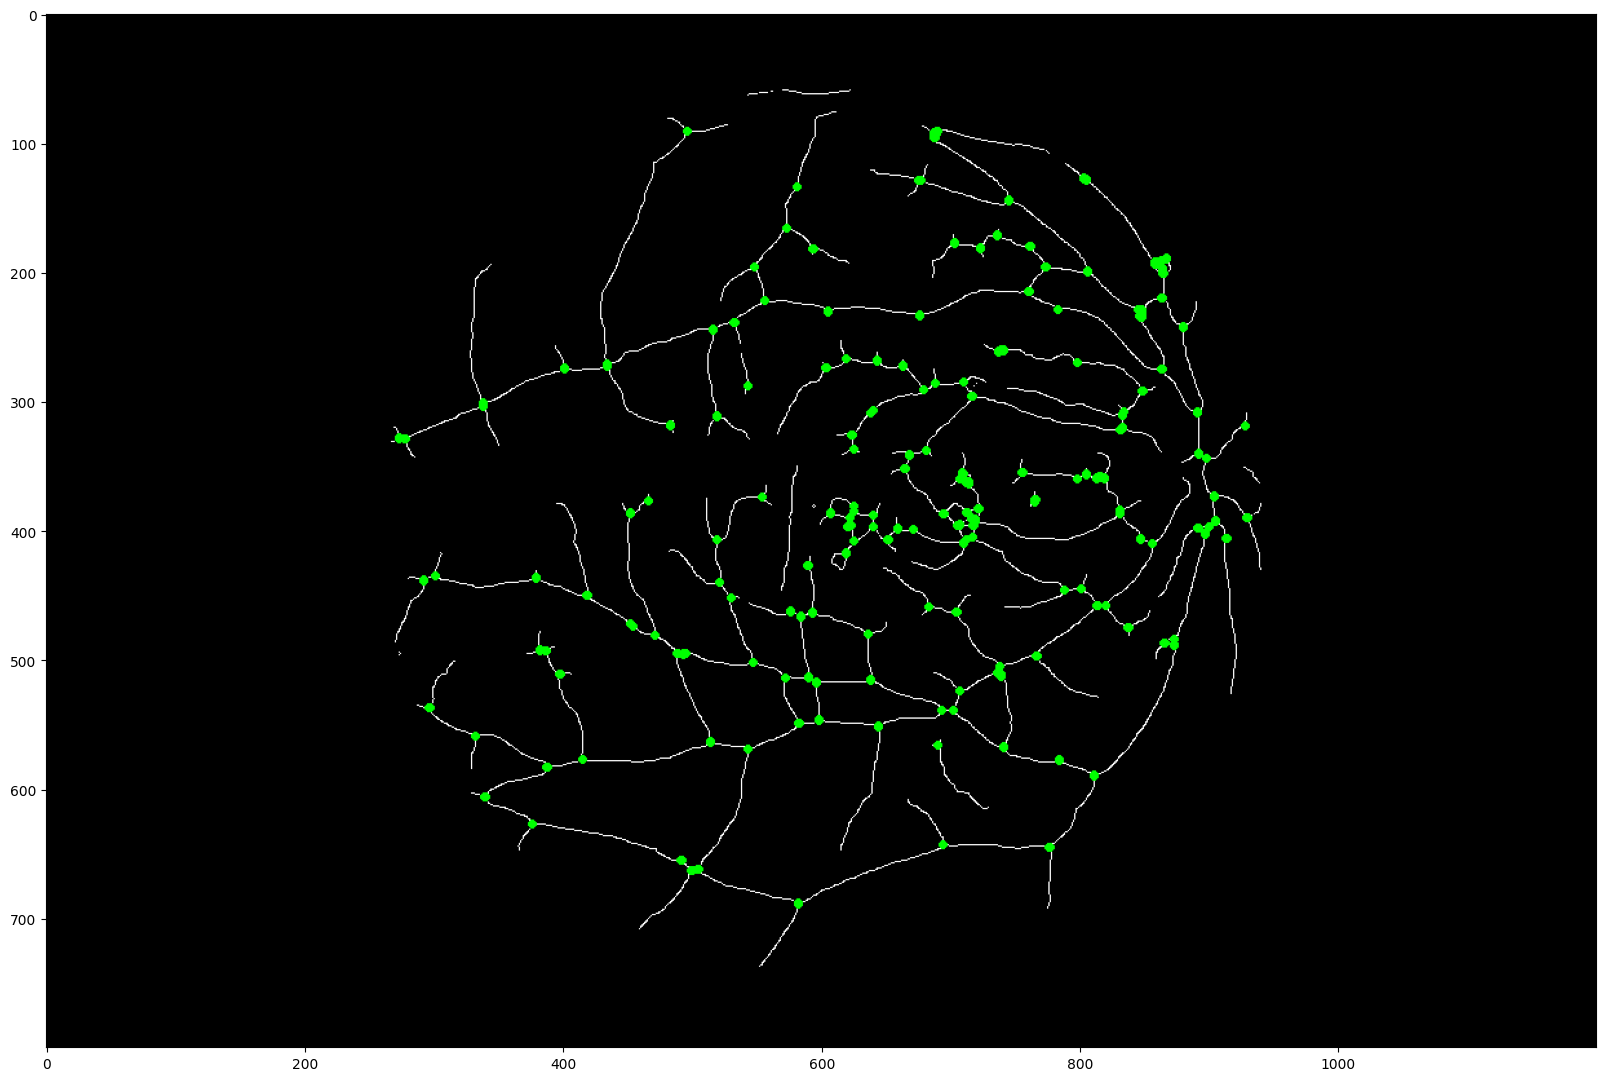

In [17]:
im, cl, d = segment.seg(img)

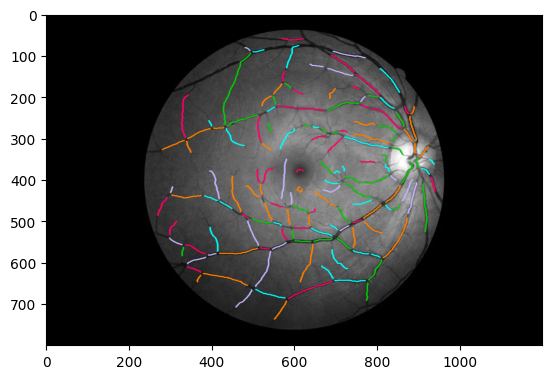

In [18]:
plt.imshow(im)

In [6]:
diameter_calc.diameter(img)

Maximum diameter: 20.504364013671875 at the point: (732, 348)
Select the vessel and press Q after selection.


error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'pointPolygonTest'
> Overload resolution failed:
>  - Can't parse 'pt'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt'. Sequence item with index 0 has a wrong type


In how many parts you want to divide the selected vessel (Please enter an integer <=5):   2


Select the required part and press Q.


TypeError: object of type 'NoneType' has no len()